关于支撑剂浓度的敏感性分析


(42, 6)
(42, 1)
(4, 6)
(4, 1)
test accuracy: 0.063725
gamma <tf.Variable 'gamma:0' shape=() dtype=float32, numpy=0.5983654>
beta <tf.Variable 'beta:0' shape=() dtype=float32, numpy=0.68067116>


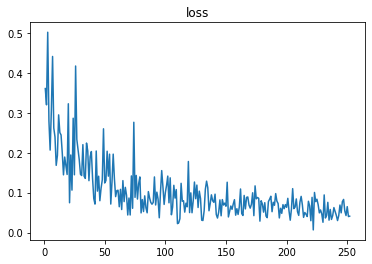

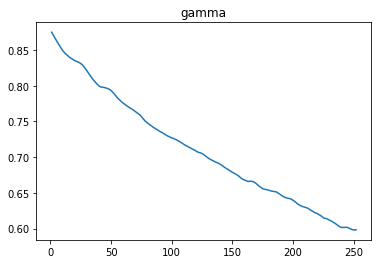

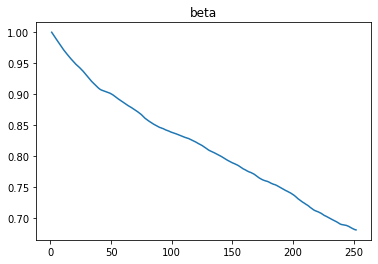

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("C_hi支撑剂浓度敏感性分析.xlsx",sheet_name="支撑剂浓度流速单独考虑",header=0,index_col=0)
  data = np.array(data_total)
  # print(data)
  features = data[:,[2,8,9,10,12,14]]
  target = data[:,[13]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建含物理约束的神经网络模型
class BASE(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.gamma = tf.Variable(tf.constant(0.875),name='gamma')####使用单变量定义防止更新不统一
      self.beta = tf.Variable(tf.constant(1.),name='beta')
      # self.gamma = tf.constant(0.6)
      # self.beta = tf.constant(0.66)
      self.dense1 = tf.keras.layers.Dense(units=16, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):
    ####在call方法中将整个表达式写好
    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    C_Mi = x[:,1:2]
    PFR = x[:,2:3]
    log_Qf = x[:,5:]
    Ki = x[:,3:4]
    index = [0,1,2,4,5]
    x = np.array(x)
    x = x[:,index]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    first_principle = self.gamma*tf.ones((inputs.shape[0],1))*PFR*Ki*C_Mi*tf.pow(log_Qf,self.beta)
    output = first_principle+x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output,first_principle

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分

#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


BASE = BASE()
loss_list = list()
gamma_list = list()
beta_list = list()
optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred,fp = BASE(x)
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss.numpy())
        gamma_list.append(float(BASE.gamma.numpy()))
        beta_list.append(float(BASE.beta.numpy()))
    grads = tape.gradient(loss,BASE.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,BASE.variables))####使用梯度进行优化

prediction,fp_test = BASE(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看gamma的值
print("gamma",BASE.gamma)
print("beta",BASE.beta)
####对训练过程误差进行平滑

time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

plt.figure()
plt.title("gamma")
plt.plot(time,gamma_list)

plt.figure()
plt.title("beta")
plt.plot(time,beta_list)

plt.show()

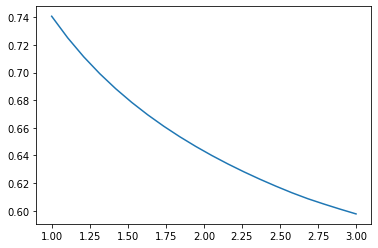

In [ ]:
import math
casing_diameter = 3 * 0.0254
wellbore_flow_rate = 0.6 * 0.159/60
orientation_down = -1
proppant_density = 2.65 * 1000
proppant_concentration = np.power(np.linspace(0,1,20)*2+1,-0.356)
proppant_concentration = np.expand_dims(proppant_concentration,axis = 1)
fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
log_Ki_2 = math.log(Ki_2,10)
log_Qf = -1 * math.log(wellbore_flow_rate,10)

Ki_3 = np.ones([20,1]) * Ki_3
log_Ki_2 = np.ones([20,1]) * log_Ki_2
log_Qf = np.ones([20,1]) * log_Qf

orientation_down = np.ones([20,1]) * orientation_down
PFR = PFR * np.ones([20,1])
Ki_ = np.ones([20,1]) * Ki_1

data_base_down = np.hstack((orientation_down,proppant_concentration,PFR,Ki_3,log_Ki_2,log_Qf))
pre,fp = BASE(data_base_down)
pre = np.array(pre)
fp = np.array(fp)
time = np.linspace(0,1,20)*2+1


plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("支撑剂浓度融合.csv")
fp = pd.DataFrame(fp)
fp.to_csv("支撑剂浓度fp.csv")

(42, 4)
(42, 1)
(4, 4)
(4, 1)
test accuracy: 0.100768
平滑前长度 252
平滑后长度 202


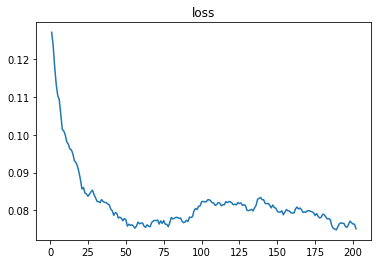

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("C_hi支撑剂浓度敏感性分析.xlsx",sheet_name="支撑剂浓度国际单位制",
                 header=0,index_col=None,usecols=[3,9,10,11,14])
  data = np.array(data_total)
  features = data[:,[0,1,2,3]]
  target = data[:,[4]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建不含物理约束的神经网络模型
class MLP(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.dense1 = tf.keras.layers.Dense(units=10, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):

    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    
    output = x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分



#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


MLP = MLP()
loss_list = list()

optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred = MLP(x)
        # print(y_pred.numpy())
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        # print("batch %d : loss %f" % (batch_index,loss.numpy()))
        loss_list.append(loss.numpy())

    grads = tape.gradient(loss,MLP.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,MLP.variables))####使用梯度进行优化

prediction = MLP(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看真实结果和预测结果
# print("真实的值：",variables_test_y)
# print("预测的值：",prediction.numpy())


loss_list = smooth(loss_list,50)
time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

# plt.figure()
# plt.title("gamma")
# plt.plot(time,gamma_list)

# plt.figure()
# plt.title("beta")
# plt.plot(time,beta_list)

plt.show()



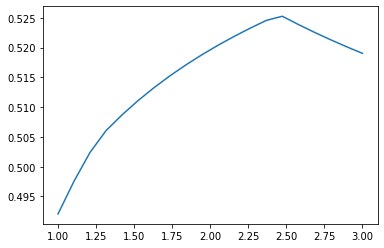

In [ ]:
import math
casing_diameter = 3 * 0.0254
wellbore_flow_rate = 0.6 * 0.159/60
orientation_down = -1
proppant_density = 2.65 * 1000
proppant_concentration = np.power(np.linspace(0,1,20)*2+1,-0.356)
proppant_concentration = np.expand_dims(proppant_concentration,axis = 1)
fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
log_Ki_2 = math.log(Ki_2,10)
log_Qf = -1 * math.log(wellbore_flow_rate,10)

Ki_3 = np.ones([20,1]) * Ki_3
log_Ki_2 = np.ones([20,1]) * log_Ki_2
log_Qf = np.ones([20,1]) * log_Qf

orientation_down = np.ones([20,1]) * orientation_down
PFR = PFR * np.ones([20,1])
Ki_ = np.ones([20,1]) * Ki_1

data_base_down = np.hstack((orientation_down,proppant_concentration,PFR,Ki_))
pre = MLP(data_base_down)
pre = np.array(pre)
time = np.linspace(0,1,20)*2+1

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("支撑剂浓度神经网络模型.csv")

颗粒直径敏感性分析

(42, 6)
(42, 1)
(4, 6)
(4, 1)
test accuracy: 0.210029
gamma <tf.Variable 'gamma:0' shape=() dtype=float32, numpy=0.66329354>
beta <tf.Variable 'beta:0' shape=() dtype=float32, numpy=0.7005411>


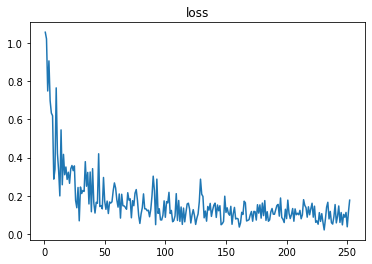

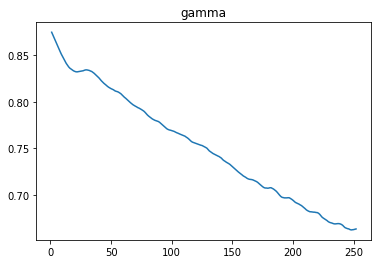

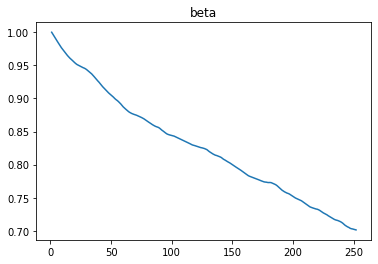

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("d_50颗粒直径敏感性分析.xlsx",sheet_name="颗粒直径流速单独考虑",header=0,index_col=0)
  data = np.array(data_total)
  # print(data)
  features = data[:,[2,8,9,10,12,14]]
  target = data[:,[13]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建含物理约束的神经网络模型
class BASE(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      # self.gamma = tf.constant(0.75)
      # self.beta = tf.constant(0.75)
      self.gamma = tf.Variable(tf.constant(0.875),name='gamma')####使用单变量定义防止更新不统一
      self.beta = tf.Variable(tf.constant(1.),name='beta')
      self.dense1 = tf.keras.layers.Dense(units=16, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):
    ####在call方法中将整个表达式写好
    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    C_Mi = x[:,1:2]
    PFR = x[:,2:3]
    log_Qf = x[:,5:]
    Ki = x[:,3:4]
    index = [0,2,4,5]
    x = np.array(x)
    x = x[:,index]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    first_principle = self.gamma*tf.ones((inputs.shape[0],1))*PFR*Ki*C_Mi*tf.pow(log_Qf,self.beta)
    output = first_principle+x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output,first_principle

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分

#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


BASE = BASE()
loss_list = list()
gamma_list = list()
beta_list = list()
optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred,fp = BASE(x)
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss.numpy())
        gamma_list.append(float(BASE.gamma.numpy()))
        beta_list.append(float(BASE.beta.numpy()))
    grads = tape.gradient(loss,BASE.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,BASE.variables))####使用梯度进行优化

prediction,fp_test = BASE(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看gamma的值
print("gamma",BASE.gamma)
print("beta",BASE.beta)
####对训练过程误差进行平滑

time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

plt.figure()
plt.title("gamma")
plt.plot(time,gamma_list)

plt.figure()
plt.title("beta")
plt.plot(time,beta_list)

plt.show()

两端点是0.16和0.44
颗粒直径600和1260微米

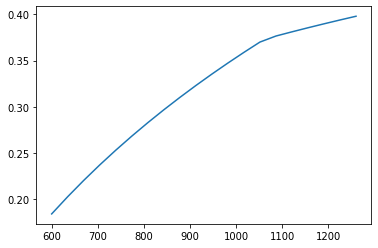

In [ ]:
import math
casing_diameter = 3 * 0.0254
wellbore_flow_rate = 0.6 * 0.159/60
orientation_up = 0
proppant_density = 2.65 * 1000
proppant_concentration = np.ones([20,1])        
fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = (600+np.linspace(0,1,20)*660)/1000000
PFR = 0.2 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)



log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])
Ki_ = np.ones([20,1]) * Ki_1

data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_3,log_Ki_2,log_Qf))
pre,fp = BASE(data_base_down)
pre = np.array(pre)
fp = np.array(fp)
time = 600+np.linspace(0,1,20)*660

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("颗粒直径融合.csv")
fp = pd.DataFrame(fp)
fp.to_csv("颗粒直径fp.csv")

(42, 4)
(42, 1)
(4, 4)
(4, 1)
test accuracy: 0.135529
平滑前长度 252
平滑后长度 202


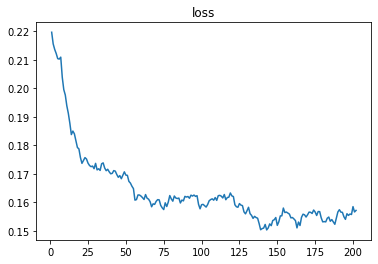

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("d_50颗粒直径敏感性分析.xlsx",sheet_name="颗粒直径国际单位制",
                 header=0,index_col=None,usecols=[3,9,10,11,14])
  data = np.array(data_total)
  features = data[:,[0,1,2,3]]
  target = data[:,[4]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建不含物理约束的神经网络模型
class MLP(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.dense1 = tf.keras.layers.Dense(units=16, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):

    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)

    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    
    output = x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分



#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


MLP = MLP()
loss_list = list()

optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred = MLP(x)
        # print(y_pred.numpy())
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        # print("batch %d : loss %f" % (batch_index,loss.numpy()))
        loss_list.append(loss.numpy())

    grads = tape.gradient(loss,MLP.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,MLP.variables))####使用梯度进行优化

prediction = MLP(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看真实结果和预测结果
# print("真实的值：",variables_test_y)
# print("预测的值：",prediction.numpy())


loss_list = smooth(loss_list,50)
time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

# plt.figure()
# plt.title("gamma")
# plt.plot(time,gamma_list)

# plt.figure()
# plt.title("beta")
# plt.plot(time,beta_list)

plt.show()



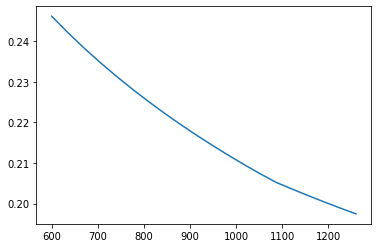

In [ ]:
import math
casing_diameter = 3 * 0.0254
wellbore_flow_rate = 0.6 * 0.159/60
orientation_up = 0
proppant_density = 2.65 * 1000
proppant_concentration = np.ones([20,1])        
fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = (600+np.linspace(0,1,20)*660)/1000000
PFR = 0.2 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_1 = np.expand_dims(Ki_1,axis = 1)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)



log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])


data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_1))
pre = MLP(data_base_down)
pre = np.array(pre)
time = 600+np.linspace(0,1,20)*660

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("颗粒直径神经网络模型.csv")

套管直径敏感性分析

(20, 6)
(20, 1)
(2, 6)
(2, 1)
test accuracy: 0.051722
gamma <tf.Variable 'gamma:0' shape=() dtype=float32, numpy=0.8167053>
beta <tf.Variable 'beta:0' shape=() dtype=float32, numpy=1.0581657>


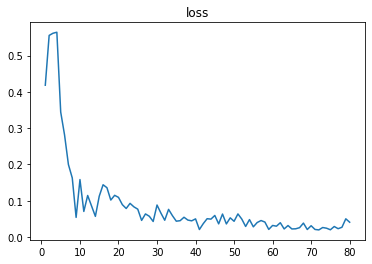

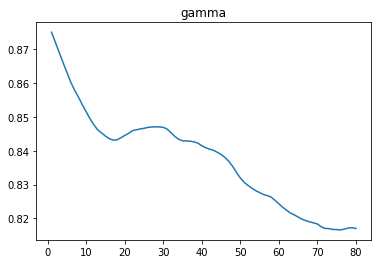

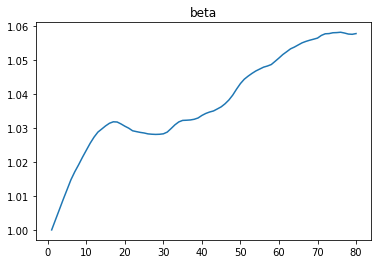

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("D_casing套管直径敏感性分析.xlsx",sheet_name="套管直径流速单独考虑",header=0,index_col=0)
  data = np.array(data_total)
  # print(data)
  features = data[:,[2,8,9,10,12,14]]
  target = data[:,[13]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建含物理约束的神经网络模型
class BASE(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.gamma = tf.Variable(tf.constant(0.875),name='gamma')####使用单变量定义防止更新不统一
      self.beta = tf.Variable(tf.constant(1.),name='beta')
      self.dense1 = tf.keras.layers.Dense(units=16, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):
    ####在call方法中将整个表达式写好
    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    C_Mi = x[:,1:2]
    PFR = x[:,2:3]
    log_Qf = x[:,5:]
    Ki = x[:,3:4]
    index = [0,2,4,5]
    x = np.array(x)
    x = x[:,index]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    first_principle = self.gamma*tf.ones((inputs.shape[0],1))*PFR*Ki*C_Mi*tf.pow(log_Qf,self.beta)
    output = first_principle+x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output,first_principle

num_epochs = 40 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分

#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


BASE = BASE()
loss_list = list()
gamma_list = list()
beta_list = list()
optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred,fp = BASE(x)
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss.numpy())
        gamma_list.append(float(BASE.gamma.numpy()))
        beta_list.append(float(BASE.beta.numpy()))
    grads = tape.gradient(loss,BASE.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,BASE.variables))####使用梯度进行优化

prediction,fp_test = BASE(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())
####查看gamma的值
print("gamma",BASE.gamma)
print("beta",BASE.beta)
####对训练过程误差进行平滑

time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

plt.figure()
plt.title("gamma")
plt.plot(time,gamma_list)

plt.figure()
plt.title("beta")
plt.plot(time,beta_list)

plt.show()

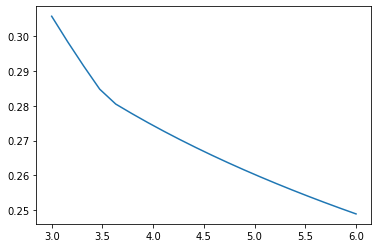

In [ ]:
import math
casing_diameter = (3 * np.linspace(0,1,20) + 3) * 0.0254 
wellbore_flow_rate = 60 * 0.159/60
orientation_up = 1
proppant_density = 2.65 * 1000
proppant_concentration = np.ones([20,1])        
fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)



log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])
Ki_1 = np.ones([20,1]) * Ki_1

data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_3,log_Ki_2,log_Qf))
pre,fp = BASE(data_base_down)
pre = np.array(pre)
fp = np.array(fp)
time = 3 * np.linspace(0,1,20) + 3

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("套管直径融合.csv")
fp = pd.DataFrame(fp)
fp.to_csv("套管直径fp.csv")

(20, 4)
(20, 1)
(2, 4)
(2, 1)
test accuracy: 0.128545
平滑前长度 80
平滑后长度 30


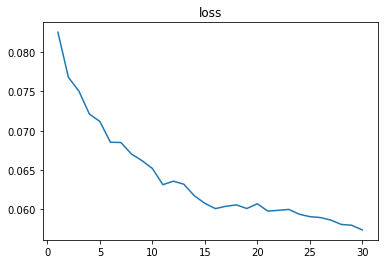

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("D_casing套管直径敏感性分析.xlsx",sheet_name="套管直径国际单位制",
                 header=0,index_col=None,usecols=[3,9,10,11,14])
  data = np.array(data_total)
  features = data[:,[0,1,2,3]]
  target = data[:,[4]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建不含物理约束的神经网络模型
class MLP(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.dense1 = tf.keras.layers.Dense(units=16, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):

    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)

    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    
    output = x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output

num_epochs = 40 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分



#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


MLP = MLP()
loss_list = list()

optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred = MLP(x)
        # print(y_pred.numpy())
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        # print("batch %d : loss %f" % (batch_index,loss.numpy()))
        loss_list.append(loss.numpy())

    grads = tape.gradient(loss,MLP.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,MLP.variables))####使用梯度进行优化

prediction = MLP(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看真实结果和预测结果
# print("真实的值：",variables_test_y)
# print("预测的值：",prediction.numpy())


loss_list = smooth(loss_list,50)
time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

# plt.figure()
# plt.title("gamma")
# plt.plot(time,gamma_list)

# plt.figure()
# plt.title("beta")
# plt.plot(time,beta_list)

plt.show()



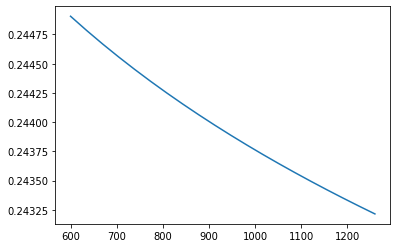

In [ ]:
import math
casing_diameter = (3 * np.linspace(0,1,20) + 3) * 0.0254 
wellbore_flow_rate = 60 * 0.159/60
orientation_up = 1
proppant_density = 2.65 * 1000
proppant_concentration = np.ones([20,1])        
fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_1 = np.expand_dims(Ki_1,axis = 1)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)

log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])


data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_1))
pre = MLP(data_base_down)
pre = np.array(pre)
time = 600+np.linspace(0,1,20)*660

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("套管直径神经网络模型.csv")

裂缝直径敏感性分析

(42, 6)
(42, 1)
(4, 6)
(4, 1)
test accuracy: 0.007038
gamma <tf.Variable 'gamma:0' shape=() dtype=float32, numpy=0.4949218>
beta <tf.Variable 'beta:0' shape=() dtype=float32, numpy=0.52223134>


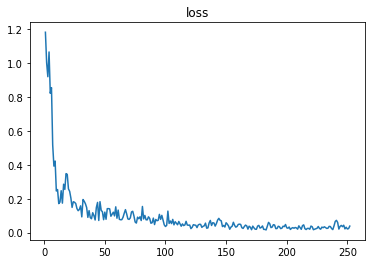

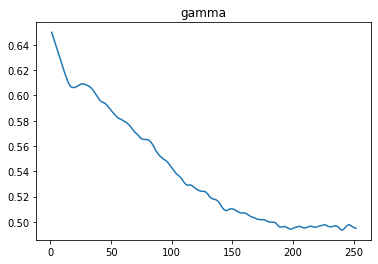

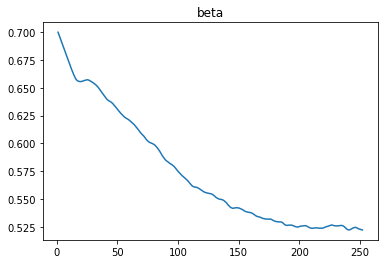

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("D_perf裂缝直径敏感性分析.xlsx",sheet_name="裂缝直径流速单独考虑",header=0,index_col=0)
  data = np.array(data_total)
  # print(data)
  features = data[:,[2,8,9,10,12,14]]
  target = data[:,[13]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建含物理约束的神经网络模型
class BASE(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.gamma = tf.Variable(tf.constant(0.65),name='gamma')####使用单变量定义防止更新不统一
      self.beta = tf.Variable(tf.constant(0.7),name='beta')
      self.dense1 = tf.keras.layers.Dense(units=10, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):
    ####在call方法中将整个表达式写好
    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    C_Mi = x[:,1:2]
    PFR = x[:,2:3]
    log_Qf = x[:,5:]
    Ki = x[:,3:4]
    index = [0,2,4,5]
    x = np.array(x)
    x = x[:,index]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    first_principle = self.gamma*tf.ones((inputs.shape[0],1))*PFR*Ki*C_Mi*tf.pow(log_Qf,self.beta)
    output = first_principle+x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output,first_principle

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分

#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


BASE = BASE()
loss_list = list()
gamma_list = list()
beta_list = list()
optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred,fp = BASE(x)
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss.numpy())
        gamma_list.append(float(BASE.gamma.numpy()))
        beta_list.append(float(BASE.beta.numpy()))
    grads = tape.gradient(loss,BASE.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,BASE.variables))####使用梯度进行优化

prediction,fp_test = BASE(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看gamma的值
print("gamma",BASE.gamma)
print("beta",BASE.beta)
####对训练过程误差进行平滑

time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

plt.figure()
plt.title("gamma")
plt.plot(time,gamma_list)

plt.figure()
plt.title("beta")
plt.plot(time,beta_list)

plt.show()

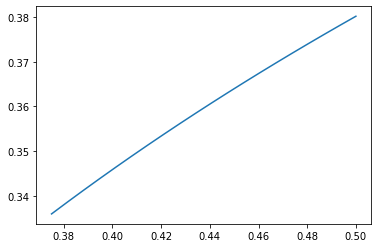

In [ ]:
import math
casing_diameter = 3 * 0.0254 
wellbore_flow_rate = 60 * 0.159/60
orientation_up = 1
proppant_density = 2.65 * 1000
proppant_concentration = np.ones([20,1])        
fluid_velocity = 1
perforation_diameter = (0.375 + 0.125 * np.linspace(0,1,20)) * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_1 = np.expand_dims(Ki_1,axis = 1)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)



log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])


data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_3,log_Ki_2,log_Qf))
pre,fp = BASE(data_base_down)
pre = np.array(pre)
time = 0.125 * np.linspace(0,1,20) + 0.375

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("裂缝直径融合.csv")

(42, 4)
(42, 1)
(4, 4)
(4, 1)
test accuracy: 0.031801
平滑前长度 252
平滑后长度 202


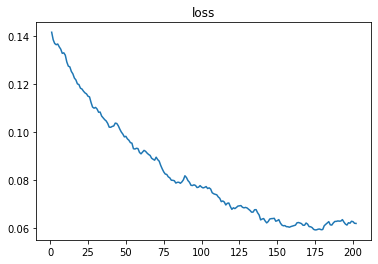

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("D_perf裂缝直径敏感性分析.xlsx",sheet_name="裂缝直径国际单位制",
                 header=0,index_col=None,usecols=[3,9,10,11,14])
  data = np.array(data_total)
  features = data[:,[0,1,2,3]]
  target = data[:,[4]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建不含物理约束的神经网络模型
class MLP(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.dense1 = tf.keras.layers.Dense(units=10, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):

    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)

    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    
    output = x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分



#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


MLP = MLP()
loss_list = list()

optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred = MLP(x)
        # print(y_pred.numpy())
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        # print("batch %d : loss %f" % (batch_index,loss.numpy()))
        loss_list.append(loss.numpy())

    grads = tape.gradient(loss,MLP.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,MLP.variables))####使用梯度进行优化

prediction = MLP(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看真实结果和预测结果
# print("真实的值：",variables_test_y)
# print("预测的值：",prediction.numpy())


loss_list = smooth(loss_list,50)
time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

# plt.figure()
# plt.title("gamma")
# plt.plot(time,gamma_list)

# plt.figure()
# plt.title("beta")
# plt.plot(time,beta_list)

plt.show()



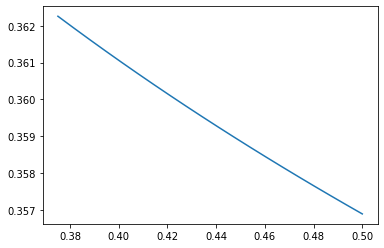

In [ ]:
import math
casing_diameter = 3 * 0.0254 
wellbore_flow_rate = 60 * 0.159/60
orientation_up = 1
proppant_density = 2.65 * 1000
proppant_concentration = np.ones([20,1])        
fluid_velocity = 1
perforation_diameter = (0.375 + 0.125 * np.linspace(0,1,20)) * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_1 = np.expand_dims(Ki_1,axis = 1)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)



log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])

data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_1))
pre = MLP(data_base_down)
pre = np.array(pre)
time = 0.375 + 0.125 * np.linspace(0,1,20)

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("裂缝直径神经网络模型.csv")

流速的敏感性

(31, 6)
(31, 1)
(3, 6)
(3, 1)
test accuracy: 0.184564
gamma <tf.Variable 'gamma:0' shape=() dtype=float32, numpy=0.6195319>
beta <tf.Variable 'beta:0' shape=() dtype=float32, numpy=0.7339891>


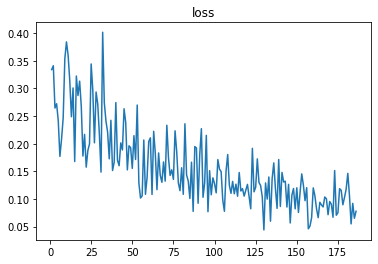

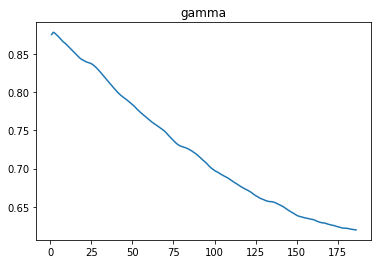

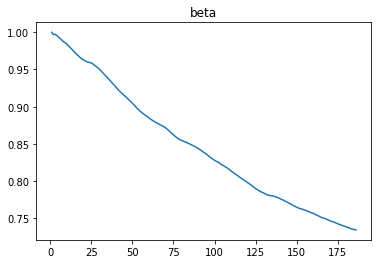

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("Q_f流速敏感性分析.xlsx",sheet_name="流速流速单独考虑",header=0,index_col=0)
  data = np.array(data_total)
  # print(data)
  features = data[:,[2,8,9,10,12,14]]
  target = data[:,[13]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建含物理约束的神经网络模型
class BASE(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.gamma = tf.Variable(tf.constant(0.875),name='gamma')####使用单变量定义防止更新不统一
      self.beta = tf.Variable(tf.constant(1.),name='beta')
      self.dense1 = tf.keras.layers.Dense(units=10, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):
    ####在call方法中将整个表达式写好
    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    C_Mi = x[:,1:2]
    PFR = x[:,2:3]
    log_Qf = x[:,5:]
    Ki = x[:,3:4]
    index = [0,2,4,5]
    x = np.array(x)
    x = x[:,index]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    first_principle = self.gamma*tf.ones((inputs.shape[0],1))*PFR*Ki*C_Mi*tf.pow(log_Qf,self.beta)
    output = first_principle+x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output,first_principle

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分

#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


BASE = BASE()
loss_list = list()
gamma_list = list()
beta_list = list()
optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred,fp = BASE(x)
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss.numpy())
        gamma_list.append(float(BASE.gamma.numpy()))
        beta_list.append(float(BASE.beta.numpy()))
    grads = tape.gradient(loss,BASE.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,BASE.variables))####使用梯度进行优化

prediction,fp_test = BASE(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看gamma的值
print("gamma",BASE.gamma)
print("beta",BASE.beta)
####对训练过程误差进行平滑

time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

plt.figure()
plt.title("gamma")
plt.plot(time,gamma_list)

plt.figure()
plt.title("beta")
plt.plot(time,beta_list)

plt.show()

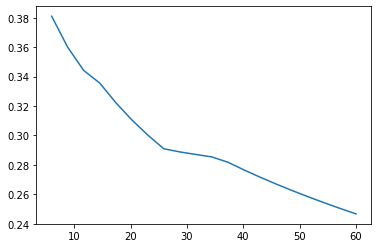

In [ ]:
import math
casing_diameter = 3 * 0.0254
wellbore_flow_rate = (6+np.linspace(0,1,20)*54) * 0.159/60
wellbore_flow_rate = np.expand_dims(wellbore_flow_rate, axis =1)
orientation_up = 1
proppant_density = 2.65 * 1000
proppant_concentration = np.ones([20,1])

fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
log_Ki_2 = math.log(Ki_2,10)


Ki_3 = np.ones([20,1]) * Ki_3
log_Ki_2 = np.ones([20,1]) * log_Ki_2
log_Qf = -np.log10(wellbore_flow_rate)

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])
Ki_ = np.ones([20,1]) * Ki_1

data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_3,log_Ki_2,log_Qf))
pre,fp = BASE(data_base_down)
pre = np.array(pre)
time = 6+np.linspace(0,1,20)*54


plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("流速融合.csv")

(31, 4)
(31, 1)
(3, 4)
(3, 1)
test accuracy: 0.025291
平滑前长度 186
平滑后长度 136


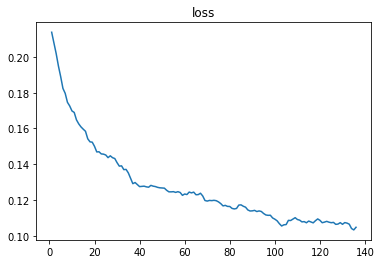

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("Q_f流速敏感性分析.xlsx",sheet_name="流速国际单位制",
                 header=0,index_col=None,usecols=[3,9,10,11,14])
  data = np.array(data_total)
  features = data[:,[0,1,2,3]]
  target = data[:,[4]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建不含物理约束的神经网络模型
class MLP(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.dense1 = tf.keras.layers.Dense(units=10, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):

    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)

    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    
    output = x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分



#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


MLP = MLP()
loss_list = list()

optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred = MLP(x)
        # print(y_pred.numpy())
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        # print("batch %d : loss %f" % (batch_index,loss.numpy()))
        loss_list.append(loss.numpy())

    grads = tape.gradient(loss,MLP.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,MLP.variables))####使用梯度进行优化

prediction = MLP(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看真实结果和预测结果
# print("真实的值：",variables_test_y)
# print("预测的值：",prediction.numpy())


loss_list = smooth(loss_list,50)
time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

# plt.figure()
# plt.title("gamma")
# plt.plot(time,gamma_list)

# plt.figure()
# plt.title("beta")
# plt.plot(time,beta_list)

plt.show()



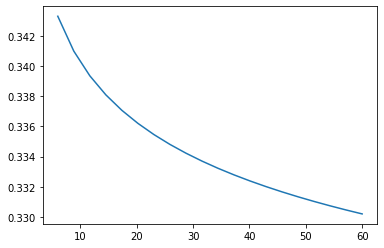

In [ ]:
import math
casing_diameter = 3 * 0.0254
wellbore_flow_rate = (6+np.linspace(0,1,20)*54) * 0.159/60
wellbore_flow_rate = np.expand_dims(wellbore_flow_rate, axis =1)
orientation_up = 1
proppant_density = 2.65 * 1000
proppant_concentration = np.ones([20,1])

fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
log_Ki_2 = math.log(Ki_2,10)


Ki_3 = np.ones([20,1]) * Ki_3
log_Ki_2 = np.ones([20,1]) * log_Ki_2
log_Qf = -np.log10(wellbore_flow_rate)

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])
Ki_ = np.ones([20,1]) * Ki_1

data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_))
pre = MLP(data_base_down)
pre = np.array(pre)
time = 6+np.linspace(0,1,20)*54

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("流速神经网络模型.csv")

支撑剂密度

(52, 6)
(52, 1)
(5, 6)
(5, 1)
test accuracy: 0.037389
gamma <tf.Variable 'gamma:0' shape=() dtype=float32, numpy=0.64431477>
beta <tf.Variable 'beta:0' shape=() dtype=float32, numpy=0.6221282>


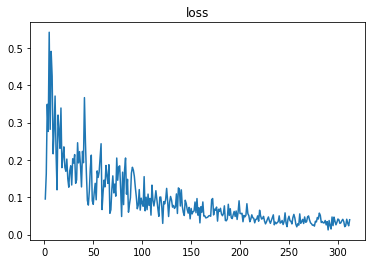

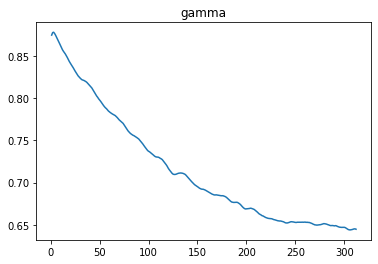

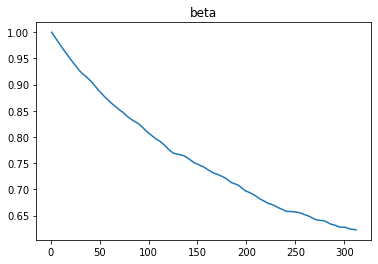

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("rho_s支撑剂密度敏感性分析.xlsx",sheet_name="支撑剂密度流速单独考虑",header=0,index_col=0)
  data = np.array(data_total)
  # print(data)
  features = data[:,[2,8,9,10,12,14]]
  target = data[:,[13]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建含物理约束的神经网络模型
class BASE(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.gamma = tf.Variable(tf.constant(0.875),name='gamma')####使用单变量定义防止更新不统一
      self.beta = tf.Variable(tf.constant(1.),name='beta')
      self.dense1 = tf.keras.layers.Dense(units=10, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):
    ####在call方法中将整个表达式写好
    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    C_Mi = x[:,1:2]
    PFR = x[:,2:3]
    log_Qf = x[:,5:]
    Ki = x[:,3:4]
    index = [0,2,4,5]
    x = np.array(x)
    x = x[:,index]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    first_principle = self.gamma*tf.ones((inputs.shape[0],1))*PFR*Ki*C_Mi*tf.pow(log_Qf,self.beta)
    output = first_principle+x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output,first_principle

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分

#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


BASE = BASE()
loss_list = list()
gamma_list = list()
beta_list = list()
optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred,fp = BASE(x)
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss.numpy())
        gamma_list.append(float(BASE.gamma.numpy()))
        beta_list.append(float(BASE.beta.numpy()))
    grads = tape.gradient(loss,BASE.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,BASE.variables))####使用梯度进行优化

prediction,fp_test = BASE(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看gamma的值
print("gamma",BASE.gamma)
print("beta",BASE.beta)
####对训练过程误差进行平滑

time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

plt.figure()
plt.title("gamma")
plt.plot(time,gamma_list)

plt.figure()
plt.title("beta")
plt.plot(time,beta_list)

plt.show()

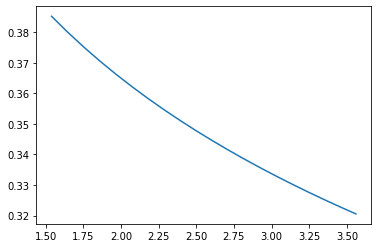

In [ ]:
import math
casing_diameter = 3 * 0.0254 
wellbore_flow_rate = 60 * 0.159/60
orientation_up = 1
proppant_density = (1.54+2.02*np.linspace(0,1,20)) * 1000

proppant_concentration = np.ones([20,1])        
fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_1 = np.expand_dims(Ki_1,axis = 1)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)



log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])


data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_3,log_Ki_2,log_Qf))
pre,fp = BASE(data_base_down)
pre = np.array(pre)
time = 1.54+2.02*np.linspace(0,1,20)

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("支撑剂密度融合.csv")

(52, 4)
(52, 1)
(5, 4)
(5, 1)
test accuracy: 0.076902
平滑前长度 312
平滑后长度 262


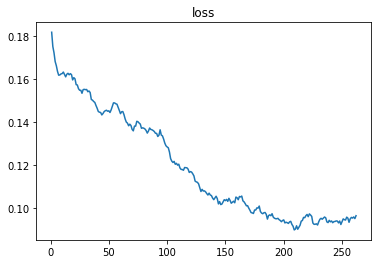

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("rho_s支撑剂密度敏感性分析.xlsx",sheet_name="支撑剂密度国际单位制",
                 header=0,index_col=None,usecols=[3,9,10,11,14])
  data = np.array(data_total)
  features = data[:,[0,1,2,3]]
  target = data[:,[4]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建不含物理约束的神经网络模型
class MLP(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.dense1 = tf.keras.layers.Dense(units=10, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):

    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)

    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    
    output = x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分



#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


MLP = MLP()
loss_list = list()

optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred = MLP(x)
        # print(y_pred.numpy())
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        # print("batch %d : loss %f" % (batch_index,loss.numpy()))
        loss_list.append(loss.numpy())

    grads = tape.gradient(loss,MLP.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,MLP.variables))####使用梯度进行优化

prediction = MLP(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看真实结果和预测结果
# print("真实的值：",variables_test_y)
# print("预测的值：",prediction.numpy())


loss_list = smooth(loss_list,50)
time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

# plt.figure()
# plt.title("gamma")
# plt.plot(time,gamma_list)

# plt.figure()
# plt.title("beta")
# plt.plot(time,beta_list)

plt.show()



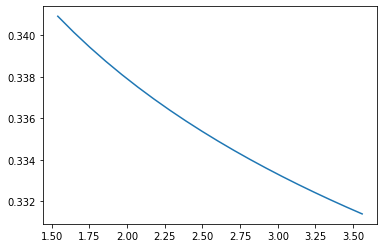

In [ ]:
import math
casing_diameter = 3 * 0.0254 
wellbore_flow_rate = 60 * 0.159/60
orientation_up = 1
proppant_density = (1.54+2.02*np.linspace(0,1,20)) * 1000

proppant_concentration = np.ones([20,1])        
fluid_velocity = 1
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_1 = np.expand_dims(Ki_1,axis = 1)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)



log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])


data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_1))
pre = MLP(data_base_down)
pre = np.array(pre)
time = 1.54+2.02*np.linspace(0,1,20)

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("支撑剂密度神经网络模型.csv")

流体粘度

(63, 6)
(63, 1)
(7, 6)
(7, 1)
test accuracy: 0.076412
gamma <tf.Variable 'gamma:0' shape=() dtype=float32, numpy=0.68419147>
beta <tf.Variable 'beta:0' shape=() dtype=float32, numpy=0.7770263>


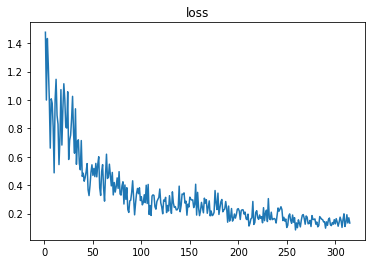

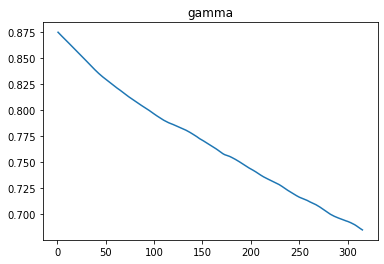

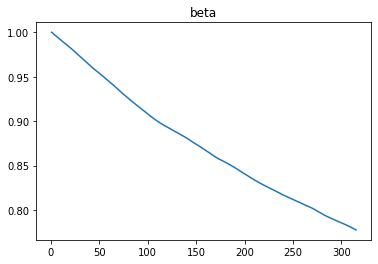

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("mu_f流体粘度敏感性分析.xlsx",sheet_name="流体粘度流速单独考虑",header=0,index_col=0)
  data = np.array(data_total)
  # print(data)
  features = data[:,[2,8,9,10,12,14]]
  target = data[:,[13]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建含物理约束的神经网络模型
class BASE(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.gamma = tf.Variable(tf.constant(0.875),name='gamma')####使用单变量定义防止更新不统一
      self.beta = tf.Variable(tf.constant(1.),name='beta')
      self.dense1 = tf.keras.layers.Dense(units=10, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):
    ####在call方法中将整个表达式写好
    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    C_Mi = x[:,1:2]
    PFR = x[:,2:3]
    log_Qf = x[:,5:]
    Ki = x[:,3:4]
    index = [0,2,4,5]
    x = np.array(x)
    x = x[:,index]
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    first_principle = self.gamma*tf.ones((inputs.shape[0],1))*PFR*Ki*C_Mi*tf.pow(log_Qf,self.beta)
    output = first_principle+x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output,first_principle

num_epochs = 100 ####迭代轮数
batch_size = 20 ####小批量的传入样本个数
learningrate = 0.001 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分

#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


BASE = BASE()
loss_list = list()
gamma_list = list()
beta_list = list()
optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred,fp = BASE(x)
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss.numpy())
        gamma_list.append(float(BASE.gamma.numpy()))
        beta_list.append(float(BASE.beta.numpy()))
    grads = tape.gradient(loss,BASE.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,BASE.variables))####使用梯度进行优化

prediction,fp_test = BASE(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看gamma的值
print("gamma",BASE.gamma)
print("beta",BASE.beta)
####对训练过程误差进行平滑

time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

plt.figure()
plt.title("gamma")
plt.plot(time,gamma_list)

plt.figure()
plt.title("beta")
plt.plot(time,beta_list)

plt.show()

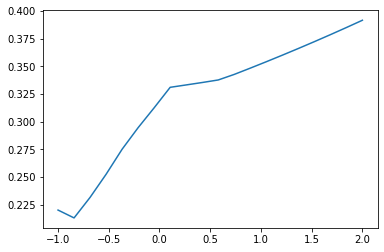

In [ ]:
import math
casing_diameter = 3 * 0.0254 
wellbore_flow_rate = 60 * 0.159/60
orientation_up = 1
proppant_density = 2.65 * 1000

proppant_concentration = np.ones([20,1])        
fluid_velocity = np.power(10,-1+3*np.linspace(0,1,20))
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * fluid_velocity * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_1 = np.expand_dims(Ki_1,axis = 1)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * fluid_velocity * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)



log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])


data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_3,log_Ki_2,log_Qf))
pre,fp = BASE(data_base_down)
pre = np.array(pre)
time = -1+3*np.linspace(0,1,20)

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("流体粘度融合.csv")

(63, 4)
(63, 1)
(7, 4)
(7, 1)
test accuracy: 0.178372
平滑前长度 378
平滑后长度 328


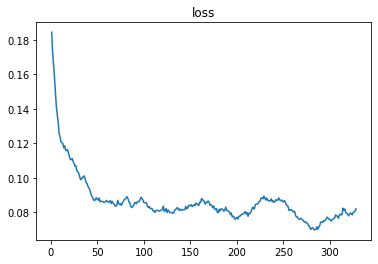

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

####准备数据集
def prepare_data():
  data_total = pd.read_excel("mu_f流体粘度敏感性分析.xlsx",sheet_name="流体粘度国际单位制",
                 header=0,index_col=None,usecols=[3,9,10,11,14])
  data = np.array(data_total)
  features = data[:,[0,1,2,3]]
  target = data[:,[4]]
  return features, target

####拆分数据集，size是拆分比例
def split(features,target,size):
  shuffled_indices=np.random.permutation(features.shape[0])
  test_set_size=int(features.shape[0]*size)
  test_indices =shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return features[train_indices],target[train_indices],features[test_indices],target[test_indices]

def scale(data):
  return sklearn.preprocessing.scale(data)

####小批量梯度下降，batch_size是批量的样本个数
def get_batch(features,target,batch_size):
  index = np.random.randint(0,features.shape[0],batch_size)
  return features[index,:],target[index] 

####使用平滑窗对训练过程的损失函数值数据进行平滑处理,data是列表格式
def smooth(data,window_size):
  print("平滑前长度",len(data))
  data_new = list()
  for i in range(int(window_size/2),len(data)-int(window_size/2)):
    data_new.append(sum(data[i-int(window_size/2):i+int(window_size/2)])/window_size)
  print("平滑后长度",len(data_new))
  return data_new


####搭建不含物理约束的神经网络模型
class MLP(tf.keras.Model):
  def __init__(self):
      super().__init__()
      #####将所有需要迭代优化的变量放在类名的变量中
      self.flatten = tf.keras.layers.Flatten()
      self.dense1 = tf.keras.layers.Dense(units=10, activation=tf.nn.leaky_relu)
      self.dense2 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
      self.dense3 = tf.keras.layers.Dense(units=1)

  def call(self,inputs):

    x = self.flatten(inputs) ####的格式是[Q_f，方向，C_Mi，PFR，Ki^{-0.05},log_Ki,log(Q_f)]
    x = tf.convert_to_tensor(x, dtype = tf.float32)

    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    
    output = x
    # output = tf.nn.relu(1-tf.nn.relu(1-output)) ####添加物理边界约束
    # print(output)
    return output

num_epochs = 60 ####迭代轮数
batch_size = 10 ####小批量的传入样本个数
learningrate = 0.003 ####学习率
size = 0.1     ####训练集和测试集的拆分比例

variables,PTE = prepare_data() ####将数据集导入
variables_train_x,variables_train_y,variables_test_x,variables_test_y = split(variables,PTE,size) ####数据集拆分



#####这步的格式必须满足样例要求才行
print(variables_train_x.shape)
print(variables_train_y.shape)
print(variables_test_x.shape)
print(variables_test_y.shape)

# print(variables_train_x[:10,:])
# print(variables_train_y[:10,:])
# variables_train_x = scale(variables_train_x)
# variables_test_x = scale(variables_test_x)


MLP = MLP()
loss_list = list()

optimizer = tf.keras.optimizers.Adam(learning_rate = learningrate)
num_batches = int(variables_train_x.shape[0] * num_epochs // batch_size)
####开始求导迭代优化
for batch_index in range(num_batches):
    x,y = get_batch(variables_train_x,variables_train_y,batch_size)
    x = tf.convert_to_tensor(x, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    with tf.GradientTape() as tape:
        y_pred = MLP(x)
        # print(y_pred.numpy())
        loss = tf.keras.losses.mean_absolute_error(y_true = y, y_pred = y_pred)
        loss = tf.reduce_mean(loss)
        # print("batch %d : loss %f" % (batch_index,loss.numpy()))
        loss_list.append(loss.numpy())

    grads = tape.gradient(loss,MLP.variables)
    optimizer.apply_gradients(grads_and_vars = zip(grads,MLP.variables))####使用梯度进行优化

prediction = MLP(variables_test_x)
prediction = tf.nn.relu(1-tf.nn.relu(1-(prediction)))
loss_prediction = tf.keras.losses.mean_absolute_error(y_true = variables_test_y, y_pred = prediction)
loss_prediction = tf.reduce_mean(loss_prediction)

####求测试集上的平均绝对值误差
print("test accuracy: %f"%loss_prediction.numpy())

####查看真实结果和预测结果
# print("真实的值：",variables_test_y)
# print("预测的值：",prediction.numpy())


loss_list = smooth(loss_list,50)
time = np.arange(1,len(loss_list)+1)

####画图
plt.figure()
plt.title("loss")
plt.plot(time,loss_list)

# plt.figure()
# plt.title("gamma")
# plt.plot(time,gamma_list)

# plt.figure()
# plt.title("beta")
# plt.plot(time,beta_list)

plt.show()



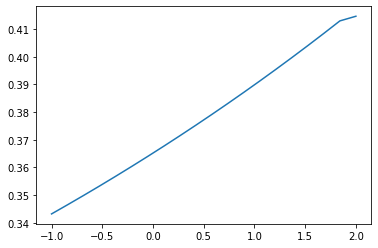

In [ ]:
import math
casing_diameter = 3 * 0.0254 
wellbore_flow_rate = 60 * 0.159/60
orientation_up = 1
proppant_density = 2.65 * 1000

proppant_concentration = np.ones([20,1])        
fluid_velocity = np.power(10,-1+3*np.linspace(0,1,20))
perforation_diameter = 0.375 * 0.0254
proppant_diameter = 600/1000000
PFR = 0.6 
Ki = (4 * proppant_density * proppant_diameter * proppant_diameter * wellbore_flow_rate)/(18 * 3.1415926 * fluid_velocity * perforation_diameter * casing_diameter * casing_diameter)
Ki_1 = np.power(Ki,-0.05)
Ki_1 = np.expand_dims(Ki_1,axis = 1)
Ki_2 = (4 * proppant_density * proppant_diameter * proppant_diameter)/(18 * 3.1415926 * fluid_velocity * perforation_diameter * casing_diameter * casing_diameter)
Ki_3 = np.power(Ki_2,-0.05)
Ki_3 = np.expand_dims(Ki_3,axis = 1)
log_Ki_2 = np.log10(Ki_2)
log_Ki_2 = np.expand_dims(log_Ki_2,axis = 1)
log_Qf = -1 * np.log10(wellbore_flow_rate)



log_Qf = np.ones([20,1]) * log_Qf

orientation_up = np.ones([20,1]) * orientation_up
PFR = PFR * np.ones([20,1])


data_base_down = np.hstack((orientation_up,proppant_concentration,PFR,Ki_1))
pre = MLP(data_base_down)
pre = np.array(pre)
time = -1+3*np.linspace(0,1,20)

plt.figure()
plt.plot(time,pre)
plt.show()

pre = pd.DataFrame(pre)
pre.to_csv("流体粘度神经网络模型.csv")

In [ ]:
import numpy as np
a = (0.223-0.344)/3
a

-0.040333333333333325

In [ ]:
import numpy as np
b = (np.power(-np.log10(0.159),0.429)-np.power(-np.log10(0.0159),0.429))/54
b

-0.007006379277011419